In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Local imports
!pip install zat
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix

# Printing versions
print('zat: {:s}'.format(zat.__version__))
print('Numpy: {:s}'.format(np.__version__))


     |████████████████████████████████| 225kB 19.5MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
zat: 0.4.3
Numpy: 1.19.5


## From Zeek log to Pandas DataFrame

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create a Pandas dataframe from a Zeek log
log_to_df = LogToDataFrame()
zeek_df = log_to_df.create_dataframe('/content/drive/MyDrive/Universita/Magistrale/Tesi/ZeekML/Logs/modbus_ctf.log')

zeek_df.tail()




,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,func,exception
ts,,,,,,,
2021-05-21 15:53:06.793776989,C5EYUN2Ajzu1wqpX9l,84.17.59.156,54575,192.168.1.4,502,READ_INPUT_REGISTERS,NaN
2021-05-21 15:56:09.396097183,CaVKg3LlQylorrAk8,31.156.204.193,50654,192.168.1.4,502,READ_COILS_EXCEPTION,NaN
2021-05-21 15:56:09.396097183,CaVKg3LlQylorrAk8,31.156.204.193,50654,192.168.1.4,502,READ_COILS_EXCEPTION,ILLEGAL_DATA_ADDRESS
2021-05-21 15:56:39.888426065,CqMJL01UKy6a4414a5,141.250.5.13,39748,192.168.1.4,502,READ_INPUT_REGISTERS,NaN
2021-05-21 15:56:39.936956167,CqMJL01UKy6a4414a5,141.250.5.13,39748,192.168.1.4,502,READ_HOLDING_REGISTERS,NaN


#Modbus func code Histogram

     |████████████████████████████████| 61kB 7.4MB/s 


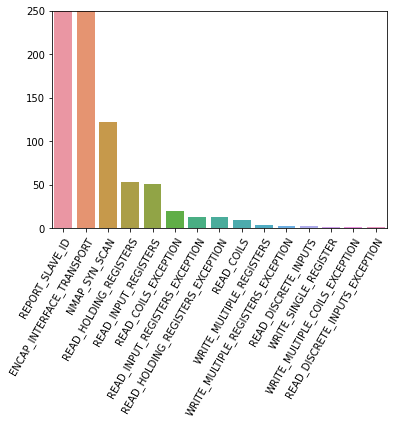

<Figure size 432x288 with 0 Axes>

In [4]:
import seaborn
!pip install tikzplotlib
import tikzplotlib
#print(zeek_df['pdu_type'].value_counts())
#zeek_df['pdu_type'].value_counts().plot.bar()


#plt.hist(zeek_df['pdu_type'], log=True) 

modbus_fc_plot= seaborn.countplot(data=zeek_df, x='func', order=zeek_df.func.value_counts().index)
#s7_fc_plot.set(yscale="log")
#set limits

modbus_fc_plot.set_xticklabels(modbus_fc_plot.get_xticklabels(),rotation=60,ha="right",rotation_mode='anchor')
plt.ylim(0, 250)

plt.xlabel("", size=12)
plt.ylabel("", size=12)

tikzplotlib.save("test.tex")
plt.show()

plt.savefig("modbus.pdf", bbox_inches='tight')



##Modbus Function Code requests in Latex

In [ ]:
print(zeek_df['func'].value_counts().to_latex())

\begin{tabular}{lr}
\toprule
{} &  func \\
\midrule
ENCAP\_INTERFACE\_TRANSPORT          &   226 \\
unknown-218                        &   177 \\
READ\_HOLDING\_REGISTERS             &   166 \\
REPORT\_SLAVE\_ID                    &   146 \\
WRITE\_MULTIPLE\_REGISTERS           &    98 \\
WRITE\_MULTIPLE\_REGISTERS\_EXCEPTION &    35 \\
READ\_INPUT\_REGISTERS\_EXCEPTION     &     2 \\
\bottomrule
\end{tabular}



# Enrichment (City)


Deleting rows that include local IP address



In [5]:
zeek_df = zeek_df[~zeek_df['id.orig_h'].isin(['192.168.1.7'])]

     |████████████████████████████████| 26.1MB 148kB/s 
     |████████████████████████████████| 286kB 32.8MB/s 
  Created wheel for maxminddb-geolite2: filename=maxminddb_geolite2-2018.703-cp37-none-any.whl size=26407038 sha256=b493807a51a7e4afa3fc2141131fc8699134c9a047ddec3bd27a0fa19e515aa0
  Stored in directory: /root/.cache/pip/wheels/94/69/0a/4453d83e882e2c55aa8c8b5b37342e0b4acddb92e808fa9664
  Created wheel for maxminddb: filename=maxminddb-2.0.3-py2.py3-none-any.whl size=15284 sha256=ef888cc6397054bd3f21de20a50ff464e60736c5324baf9304c760a27b990a57
  Stored in directory: /root/.cache/pip/wheels/55/0e/56/d16e8c8c19aced8bbd51b3e40f84208f023f9a90328c6b450f
Successfully built maxminddb-geolite2 maxminddb
188.116.60.240    1108
45.131.236.16     1017
87.16.191.239      625
217.171.70.58      256
31.156.204.193     163
212.69.141.174     154
84.17.59.156        59
62.11.2.83          31
141.250.5.13        20
78.134.108.102       6
151.41.160.3         2
Name: id.orig_h, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  app.launch_new_instance()


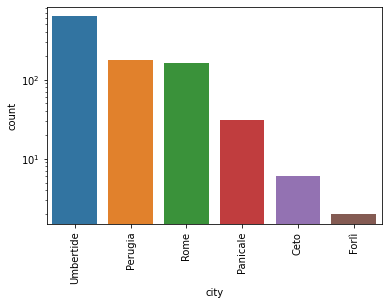

In [6]:
!pip install maxminddb-geolite2
!pip install pygeoip  

import seaborn
import pandas as pd
from geolite2 import geolite2

def get_city(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['city']['names']['en'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

geo = geolite2.reader()


# get unique IPs
unique_ips = zeek_df['id.orig_h'].unique()
# make series out of it
unique_ips = pd.Series(unique_ips, index = unique_ips)
# map IP --> city
print(zeek_df['id.orig_h'].value_counts())

zeek_df['city'] = zeek_df['id.orig_h'].map(unique_ips.apply(get_city))

#print(zeek_df['city'])



zeek_df['city'].value_counts().plot.bar()


city_plot = seaborn.countplot(data=zeek_df, x='city', order=zeek_df.city.value_counts().index)
city_plot.set(yscale="log")
plt.xticks(rotation=90)
plt.show()
#geolite2.close()




##Looking for DNS (vedi distro ip Zanero)


In [ ]:
!pip install dnspython
from dns import resolver,reversename
import dns.exception

def get_dns(ip):
    try:
        return str(resolver.query(reversename.from_address(ip), 'PTR')[0])
    except dns.exception.DNSException:
        return pd.np.nan

unique_ips = zeek_df['id.orig_h'].unique()
# we make series out of it
unique_ips = pd.Series(unique_ips, index = unique_ips)
# map IP --> country

zeek_df['dns'] = zeek_df['id.orig_h'].map(unique_ips.apply(get_dns))

print(zeek_df['id.orig_h'])
print(zeek_df['dns'].value_counts())


#zeek_df['dns'].value_counts().plot.bar()




     |████████████████████████████████| 245kB 12.2MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: please use dns.resolver.resolve() instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


ts
2021-01-04 19:24:14.341716051      71.6.167.124
2021-01-04 19:24:14.720738173      71.6.167.124
2021-01-04 19:24:15.102817059      71.6.167.124
2021-01-04 19:24:15.293833017      71.6.167.124
2021-01-04 19:24:15.485001087      71.6.167.124
                                      ...      
2021-02-05 03:13:15.631276846      71.6.146.185
2021-02-05 03:13:16.062852859      71.6.146.185
2021-02-05 03:13:16.943475008      71.6.146.185
2021-02-05 03:13:17.336333990      71.6.146.185
2021-02-05 04:41:11.212460995    192.241.204.99
Name: id.orig_h, Length: 850, dtype: category
Categories (74, object): ['102.165.30.25', '102.165.30.49', '104.206.128.38', '117.50.6.160', ...,
                          '92.118.160.9', '92.118.161.21', '92.118.161.49', '93.174.95.106']
battery.census.shodan.io.                     194
ubuntu14167124.aspadmin.net.                   40
pirate.census.shodan.io.                       34
einstein.census.shodan.io.                     31
scanner-04.ch1.censys-scanner.c

##Number of connections per actor (unique). - remove  x/y temples

 A handful of actors generates the majority of the ICS traffic.

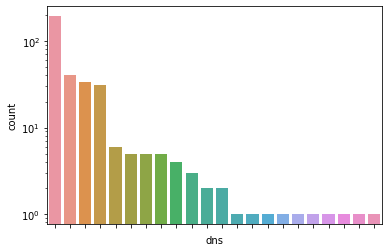

In [ ]:

actors_plot = seaborn.countplot(data=zeek_df, x='dns', order=zeek_df.dns.value_counts().index)
actors_plot.set(xticklabels=[]) 
actors_plot.set(yscale="log")
plt.show()

##Looking for ASN and Organization






In [ ]:
!pip install geoip2

import geoip2.database

#Upload maxmind geoasn then put to drive

#Generic exception, no asnexception found


def get_asn(ip):
  try:
    with geoip2.database.Reader('/content/drive/MyDrive/Universita/Magistrale/Tesi/DBs/GeoLite2-ASN.mmdb') as reader:
      response = reader.asn(ip)
      #print(response.autonomous_system_number)
      #print(response.autonomous_system_organization)
      return response.autonomous_system_number
  except:
    return pd.np.nan


def get_org(ip):
  try:
    with geoip2.database.Reader('/content/drive/MyDrive/Universita/Magistrale/Tesi/DBs/GeoLite2-ASN.mmdb') as reader:
      response = reader.asn(ip)
      #print(response.autonomous_system_organization)
      return response.autonomous_system_organization
  except:
    return pd.np.nan

unique_ips = zeek_df['id.orig_h'].unique()
# make series out of it
unique_ips = pd.Series(unique_ips, index = unique_ips)


zeek_df['asn'] = zeek_df['id.orig_h'].map(unique_ips.apply(get_asn))

zeek_df['org'] = zeek_df['id.orig_h'].map(unique_ips.apply(get_org))



     |████████████████████████████████| 1.3MB 9.8MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 153kB 58.0MB/s 
     |████████████████████████████████| 143kB 30.2MB/s 
     |████████████████████████████████| 296kB 36.0MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


##Table of all modbus activities

In [ ]:
#zeek_df[zeek_df['func'].str.contains('READ')]

zeek_df[['asn','org','func']].value_counts().head(100)
#zeek_df[['id.orig_h','dns','asn','org','func']].value_counts().head(10)

#zeek_df[['id.orig_h','dns','asn','org']].value_counts().head(50).to_latex()

asn     org                                            func                              
55536   PACSWITCH IP NETWORK                           READ_HOLDING_REGISTERS                166
9009    M247 Ltd                                       unknown-218                           160
55536   PACSWITCH IP NETWORK                           WRITE_MULTIPLE_REGISTERS               98
202425  IP Volume inc                                  REPORT_SLAVE_ID                        95
                                                       ENCAP_INTERFACE_TRANSPORT              93
10439   CARINET                                        REPORT_SLAVE_ID                        49
                                                       ENCAP_INTERFACE_TRANSPORT              47
55536   PACSWITCH IP NETWORK                           WRITE_MULTIPLE_REGISTERS_EXCEPTION     35
14061   DIGITALOCEAN-ASN                               ENCAP_INTERFACE_TRANSPORT              29
398324  CENSYS-ARIN-01               

#Function encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

le.fit(zeek_df['func'])
ef=le.transform(zeek_df['func'])


zeek_df['ef']=ef

#Pandas ASN and encoded function
asn_ef = zeek_df[['id.orig_h','ef','func']]



#asn_ef
#asn_ef= asn_ef.groupby(pd.Grouper(freq='60Min', base=30, label='right')).first()


#Pandas read csv dataframe rows from specific date and time range
asn_ef.index = pd.to_datetime(asn_ef.index)
mask = (asn_ef.index > '2021-02-05 00:00:00') & (asn_ef.index <= '2021-02-05 23:59:59')
asn_ef = asn_ef.loc[mask]


# 0 = READ_DEVICE_IDENTIFICATION
# 1 = READ_HOLDING_REGISTERS
# 2 = READ_INPUT_REGISTERS_EXCEPTION
# 3 = REPORT_SLAVE_ID
# 4 = WRITE_MULTIPLE_REGISTERS
# 5 = WRITE_MULTIPLE_REGISTERS_EXCEPTION
# 6 = unknown-218


#Find pattern
#fc_list = asn_ef.groupby('asn')['ef'].apply(list).reset_index(name='sequence').resample('60Min')
#fc_list

fc_list = asn_ef.groupby('id.orig_h')['ef'].apply(list).reset_index(name='sequence')
#fc_list = asn_ef.groupby('asn')['func'].apply(list).reset_index(name='sequence')



#6 gen 2021	27.122.12.245	[2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# 15 gen 2021 185.104.184.99	[2, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
# 25 gen 2021 93.174.95.106	[3, 0, 6, 6, 6, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
# 30 gen 71.6.199.23	[3, 0, 6, 6, 6, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0]
# 5 feb 2021 71.6.146.185	[3, 0, 6, 6, 6, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
#asn_ef_interval = asn_ef.resample('60Min')
fc_list.to_csv('pattern.csv')
asn_ef.to_csv('encoded_func.csv')

fc_list.describe()



,id.orig_h,sequence
count,11,11
unique,11,1
top,87.16.191.239,[]
freq,1,11


Shrink df to ASN and encoded function

#Pattern Matching

In [8]:

#Check if the pattern was found in any of the columns using rolling. This will give you the last index of the group matching the pattern
pattern1 = [6,6,6]
pattern2 = [6,6,6]

matched = zeek_df['ef'].rolling(len(pattern2)).apply(lambda x: all(np.equal(x, pattern2)))
matched = matched.sum(axis = 0).astype(bool)   #Sum to perform boolean OR
matched

#For each match, add the indexes of the complete pattern:
idx_matched = np.where(matched)[0]
subset = [range(match-len(pattern2)+1, match+1) for match in idx_matched]
result = pd.concat([zeek_df.iloc[subs,:] for subs in subset], axis = 0)

result


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,func,exception,city,ef
ts,,,,,,,,,
2021-05-21 15:56:39.888426065,CqMJL01UKy6a4414a5,141.250.5.13,39748,192.168.1.4,502,READ_INPUT_REGISTERS,NaN,Perugia,8
2021-05-21 15:56:39.936956167,CqMJL01UKy6a4414a5,141.250.5.13,39748,192.168.1.4,502,READ_HOLDING_REGISTERS,NaN,Perugia,6
2021-05-21 14:19:27.684533119,CFClKiXGTvRhzZN1f,87.16.191.239,37675,192.168.1.4,502,READ_HOLDING_REGISTERS_EXCEPTION,ILLEGAL_DATA_ADDRESS,Umbertide,7


##Check ASN reputation (?)